# ロジスティック回帰（教師有り学習）

#### Overview

ここから4回のレクチャーでは、ロジスティック回帰を扱います。目的変数が0または1の2値になる回帰を、ロジスティック回帰と呼びます。

0と1という数字自体には意味はありません。2値であるというところが重要です。例えば、ある電子メールが、「スパム」か「スパムでない」かや、腫瘍が「悪性」か「良性」かなどを予測するイメージです。この分類を行うために、ロジスティック関数を使います。

次の内容について学んで行きます。

    1. ロジスティック関数の基本
    2. その他の資料
    3. データの準備
    4. データの可視化
    5. データの前処理
    6. 多重共線性（Multicollinearity）について
    7. scikit-learnを使ったロジスティック回帰
    8. 学習とテスト
    9. その他の話題

#### 準備

##### Statsmodels
ここで新しいモジュールである [Statsmodels](http://statsmodels.sourceforge.net/) が必要になります。

Anacondaを利用している場合は、すでにセットアップされている可能性もありますが、インポートでエラーが出る場合は、

pip install statsmodels

または（Anacondaを使っている場合）

conda install statsmodels

として、セットアップしてください。

In [132]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import math

#プロット用です
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# 機械学習用です。
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# もう一つ、性能の評価用に
from sklearn import metrics

# エラーが出たら、セットアップをお願いします。
import statsmodels.api as sm

### Part 1: 数学的な基礎

−∞から∞までの値を入力として受け取って、常に0から1の間の値を返す関数を考えます。これをロジスティック関数（シグモイド関数＊）と呼びます。
- [シグモイド関数](https://ja.wikipedia.org/wiki/%E3%82%B7%E3%82%B0%E3%83%A2%E3%82%A4%E3%83%89%E9%96%A2%E6%95%B0)
- [Logistic Function（英語）](http://en.wikipedia.org/wiki/Logistic_function). 

式で描くとこんな感じです。

$$ \sigma (t)= \frac{1}{1+e^{-t}}$$

＊シグモイド関数は、ロジスティック関数の一種です。

式では分からないので、グラフを描いてみましょう。

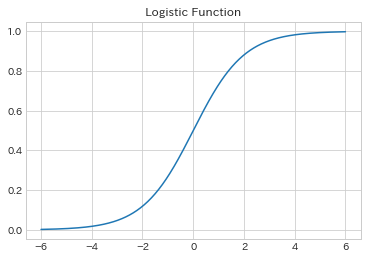

In [10]:
# ロジスティック関数
def logistic(t):
    return 1.0 / (1 + math.exp((-1.0)*t) )

# tを-6 から 6まで 500 点用意します。
t = np.linspace(-6,6,500)

# リスト内包表記で、yを用意します。
y = np.array([logistic(ele) for ele in t])
#y = np.array([1.0 / (1+np.exp((-1.0)*ele)) for ele in t])  こっちの方がいいかも

# プロットしてみましょう。
plt.plot(t,y)
plt.title(' Logistic Function ')

ロジスティック回帰の数学的な、線形回帰よりすこし複雑です。なので、ここでは詳細な説明は省いて、イメージだけ掴むようにしてみましょう。

元のデータ$x$に対して、新しい（潜在的な）変数$t$を導入します。以下のような式を考えて見ましょう。

$$ t = \beta _0 + \beta _1 x $$

これは、単回帰モデルの式と同じです。説明変数が複数あるなら、重回帰と同じになります。

これを使って、ロジスティック関数を次のように書き換えてみます。

$$ F(x)= \frac{1}{1+e^{-(\beta _0 + \beta _1 x)}}$$

何らかの方法を使って、もとのデータ$x$から、$\beta_{0}$や$\beta_{1}$を推定したいところです。

実は、ロジスティック回帰の場合、線形回帰のときの正規方程式のように、解けば答えが見付かる形には出来ません。数値的な最適化の計算で、パラメータ$\beta$を推定することになります。実際には、この部分はscikit-learnがやってくれます。数学的な背景に興味がある方は、以下の資料や、このレクチャーの最後で紹介する資料などを参考にして見てください。$F(x)$が0から1までの値しかとらないため、確率を同じだと考える事が出来る点は、1つのポイントになります。

### Part 2: その他の資料

もう少し詳しく学んで見たい場合は、次のような資料が役に立つかも知れません。

- [ロジスティック回帰の解説](http://gihyo.jp/dev/serial/01/machine-learning/0018) 技術評論社のページです

- [Andrew Ng's class notes（英語）](http://cs229.stanford.edu/notes/cs229-notes1.pdf) 16ページ目からがLogistic Regressionの解説です。

- [CMU notes（英語）](http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf) 

- [Wikipedia（英語）](http://en.wikipedia.org/wiki/Logistic_regression) 非常に丁寧な解説です。

<hr>

### Part 3: データの準備
今回使うサンプルデータは [こちら](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html)

Statsmodelsの一部として提供されているもので、1974年に行われた、女性に対する調査です。何の調査かというと、結婚している女性に対する、所謂不倫の有無を聞いた調査です。

元のデータは論文になっているの次のリンクから内容を確認することができます。
[Fair, Ray. 1978. “A Theory of Extramarital Affairs,” `Journal of Political Economy`, February, 45-61.](http://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf)

自己申告なので、データに嘘が含まれる可能性は十分にあります。このデータを選んだことにもちろん他意はありません。（元のコースで使われて居たデータをそのまま利用しました）

不倫の有無という点だけに注目して、このデータを使って、ロジスティック回帰について見ていくことにしましょう。

以下の問いに対する答えを探します。

*それぞれの女性の属性から、不倫の有無を予測できるか？*

#### データの概要

データの概要が、[Statsmodelsのwebサイト](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html) にあります。

Number of observations: 6366
Number of variables: 9
Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-colloar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

詳細が知りたい方は、元の論文を参照してみてください。

Statsmodelsには他にもサンプルデータがありますので、是非使って見てください。

### Part 4: データの可視化

まずは、データの概要を見ていきましょう。

In [62]:
# 以下のコードで、データをロードできます。fairがデータセットの名前ですが、不倫を意味する英単語は'affair'です。
df = sm.datasets.fair.load_pandas().data

In [63]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


不倫の有無を0,1で表現する新しい列名「Had_Affair」を作りましょう。
affairsが0出なければ、1。0ならそのままHad_Affairも0にします。

In [5]:
# 関数を作ります。
def affair_check(x):
    if x != 0:
        return 1
    else:
        return 0

# applyを使って、新しい列用のデータを作りましょう。
df['Had_Affair'] = df['affairs'].apply(affair_check)

In [67]:
# lambda 式を使うと...
df['Had_Affair'] = df['affairs'].apply(lambda x: 1 if x != 0 else 0)

In [69]:
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,Had_Affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


groupbyを使うと、簡単にグループ分けを作れます。

In [70]:
# 不倫の有無（Had_Affair列）でグループ分けします。
df.groupby('Had_Affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
Had_Affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


この簡単な解析からは、不倫したことがある女性は、若干年齢が上で、比較的長く結婚しており、宗教観と学歴が少し低いことがわかります。
ただ、平均値はグループ間で似たような値になっているのがわかります。

分かり易いように可視化してみましょう。

まずは、ヒストグラムから。

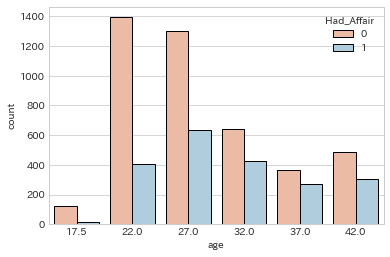

In [75]:
# 年齢分布を見てみます。
sns.countplot('age',data=df.sort_values(by='age'), hue='Had_Affair', palette='RdBu')

年齢が上がると不倫率が上がる傾向が見えます。では、結婚してからの年月はどうでしょうか？

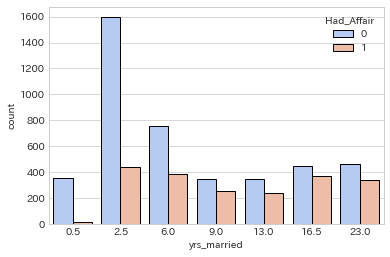

In [76]:
sns.countplot('yrs_married',data=df.sort_values(by='yrs_married'), hue='Had_Affair', palette='coolwarm')

やはり結婚から年月が経つと、不倫率が上がるようです。

子供の数はどうでしょうか？

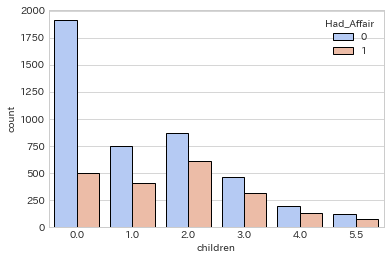

In [77]:
sns.countplot('children',data=df.sort_values('children'),hue='Had_Affair',palette='coolwarm')

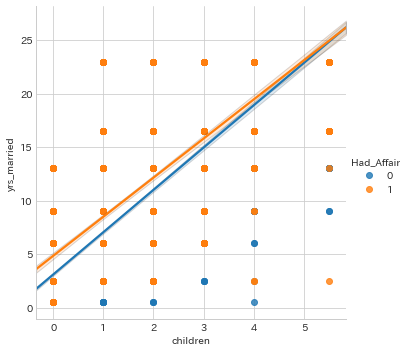

In [87]:
sns.lmplot(x='children', y='yrs_married', data=df, hue='Had_Affair')

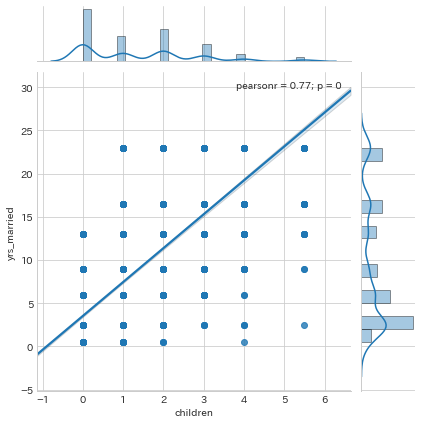

In [86]:
sns.jointplot(x='children', y='yrs_married', data=df, kind='reg') # 相関している?

子供の数が少ないと、不倫率が低いはっきりとした傾向があります。

最後は学歴を見ておきましょう。

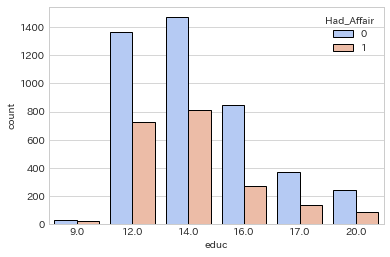

In [84]:
sns.countplot('educ',data=df.sort_values('educ'),hue='Had_Affair',palette='coolwarm')

数字が大きいほど高学歴ですが、あまり関係が無いように見えます。他の列についてやってみるのもいいかもしれません。

引き続き、回帰モデルを作ることを目指します。

<hr>

### Part 5:  データの前処理

データを見ていると、2つだけ別の列と違う性質のものがあります。Occupation と Husband's Occupation です。
これは、それぞれ奥さんとご主人の職業ですが、カテゴリー型のデータになっているので、数字の大小に意味がありません。

そこでこのような変数は、ダミー変数を導入して、その変数の0/1で表現し直すことを考えます。pandasに便利な関数があるので、実際にやってみながら説明します。

In [107]:
# カテゴリーを表現する変数を、ダミー変数に展開します。
occ_dummies = pd.get_dummies(df['occupation'])
hus_occ_dummies = pd.get_dummies(df['occupation_husb'])

# こういうことです。
occ_dummies.head()

,1.0,2.0,3.0,4.0,5.0,6.0
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,0,1,0
4,0,0,1,0,0,0


もう少し読みやすいように、列名を付けて置きます。

In [108]:
occ_dummies.columns = ['occ1','occ2','occ3','occ4','occ5','occ6']
hus_occ_dummies.columns = ['hocc1','hocc2','hocc3','hocc4','hocc5','hocc6']

今作った職業の列を追加すべく、データセットを整理しましょう。

In [109]:
# 不要になったoccupationの列と、目的変数「Had_Affair」を削除します。
X = df.drop(['occupation','occupation_husb','Had_Affair'],axis=1)

In [110]:
# ダミー変数のDataFrameを繋げます。
dummies = pd.concat([occ_dummies,hus_occ_dummies],axis=1)

すべてを連結して、説明変数のDataFrameを作ります。

In [111]:
# 説明変数XのDataFrameです。
X = pd.concat([X,dummies],axis=1)

X.head()

,rate_marriage,age,yrs_married,children,religious,educ,affairs,occ1,occ2,occ3,occ4,occ5,occ6,hocc1,hocc2,hocc3,hocc4,hocc5,hocc6
0,3.0,32.0,9.0,3.0,3.0,17.0,0.111111,0,1,0,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.230769,0,0,1,0,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,1.400000,0,0,1,0,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,16.0,0.727273,0,0,0,0,1,0,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,4.666666,0,0,1,0,0,0,0,0,0,1,0,0


Yに目的変数を格納します。

In [102]:
Y = df.Had_Affair

Y.head()

0    1
1    1
2    1
3    1
4    1
Name: Had_Affair, dtype: int64

In [103]:
Y.shape

(6366,)

<hr>

### Part 6: 多重共線性

ダミー変数を導入しましたが、ここで1つ注意点があります。ダミー変数同士は高度に相関する可能性があります。

[ダミー変数について](http://ocw.nagoya-u.jp/files/254/sonoda_kougi12.pdf)



例えば、男女を表現するのに、maleとfemaleのダミー変数を導入したとします。maleが1ならfemaleは0、その逆も成り立ちます。このように、変数同士が、互いに高い相関を示すことを、「多重共線性」と言ったりしますが、ダミー変数をすべて含めると、完全に相関する変数を回帰モデルに入れることになります。

[英語のWikipedia（multicollinearity）](http://en.wikipedia.org/wiki/Multicollinearity#Remedies_for_multicollinearity)

ひとまず、ダミー変数から、occ1とhocc1を解析から取り除くことにします。

もう1つ、affairs列も、目的変数の元になっている変数なので、これも削除しておきましょう。

In [112]:
X = X.drop('occ1',axis=1)
X = X.drop('hocc1',axis=1)

X = X.drop('affairs',axis=1)

X.head()

,rate_marriage,age,yrs_married,children,religious,educ,occ2,occ3,occ4,occ5,occ6,hocc2,hocc3,hocc4,hocc5,hocc6
0,3.0,32.0,9.0,3.0,3.0,17.0,1,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,14.0,0,1,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,0,1,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,16.0,0,0,0,1,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,0,1,0,0,0,0,0,1,0,0


最後に、Yを1次元のarrayにする必要があります。

np.ravelか、Y.valuesを使います。

In [100]:
Y = Y.values
# または、
Y = np.ravel(Y)

Y  #　別にSereisのままでも良い?

array([1, 1, 1, ..., 0, 0, 0])

### Part 7: ScikitLearnを使ったロジスティック回帰

いよいよ、実際にロジスティック回帰を行いますが、前のレクチャーで学んだ、線形回帰に非常によく似ているので、分かり易いかもしれません。

In [113]:
# LogisticRegressionクラスのインスタンスを作ります。
log_model = LogisticRegression() # fit_intercept=False, C=1e9) statsmodelsの結果に似せるためのパラメータ。

# データを使って、モデルを作ります。
log_model.fit(X,Y)

# モデルの精度を確認してみましょう。
log_model.score(X,Y)

0.72588752748978946

約73%の精度が実現できたように見えます。

ところで、実際の目的変数Yの平均値を計算してみましょう。

In [114]:
# numpyのarrayなので、平均をすぐ計算できます。
Y.mean()

0.3224945020420987

これは、作ったモデルが、常に「不倫していない（つまり0）」と出力すると、1-0.32=0.68 となり、68%の精度が得られることになります。この値よりは、73％の方が高いことがわかります。

さて次に、どの変数が予測に寄与しているか、見ていくことにしましょう。

In [119]:
log_model.coef_

array([[-0.69784551, -0.05633632,  0.10389299,  0.01818532, -0.36850664,
         0.00864737,  0.29811889,  0.60815029,  0.34651127,  0.94225955,
         0.9181501 ,  0.21995711,  0.324766  ,  0.18935412,  0.21309295,
         0.21417995]])

In [120]:
# 変数名とその係数を格納するDataFrameを作ります。
coeff_df = DataFrame([X.columns, log_model.coef_[0]]).T

In [126]:
coeff_df = DataFrame({'Feature' : X.columns, 'Coefficient' : log_model.coef_[0]}).sort_values(by='Coefficient', ascending=False)

In [127]:
coeff_df

,Coefficient,Feature
9,0.942260,occ5
10,0.918150,occ6
7,0.608150,occ3
8,0.346511,occ4
12,0.324766,hocc3
6,0.298119,occ2
11,0.219957,hocc2
15,0.214180,hocc6
14,0.213093,hocc5
13,0.189354,hocc4


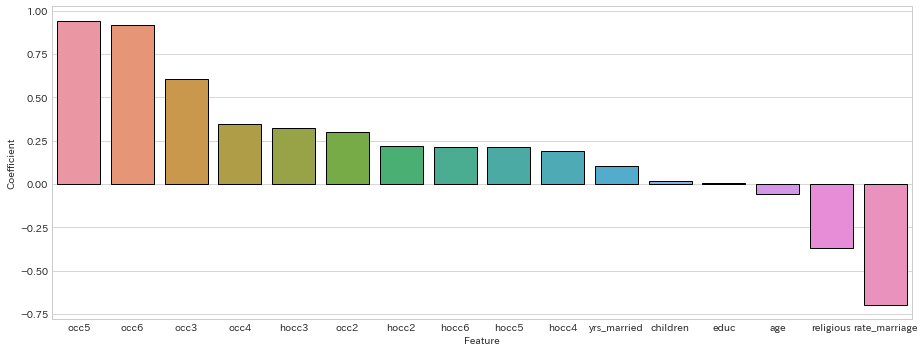

In [137]:
fig = plt.figure(figsize=(13,5))
sns.barplot(x='Feature', y='Coefficient', data=coeff_df, )
plt.tight_layout()

係数が正の場合、その変数が増えれば、不倫の可能性は増します。係数が負の場合は、その逆です。

marriage ratingが増えると、不倫の可能性は減少します。
宗教観（religiousness）が高くなると、同様に不倫の可能性は減少するようです。

ダミー変数は、学生を示す1の変数を取り除いているので、そこが基準となっていることを頭に入れておく必要がありますが、大きな値になっていれば、その職業に就いている場合に、不倫率が上がる傾向にあることは見て取れます。実際に、可視化してみるとわかります。

### Part 8: 学習とテスト

線形回帰のレクチャーでやったのと同じように、データを学習用とテスト用に分けて、モデルの性能を確認してみましょう。

In [138]:
# おなじく、train_test_splitを使います。
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# 新しいモデルを作ります。
log_model2 = LogisticRegression()

# 学習用のデータだけでモデルを鍛えます。
log_model2.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

predictメソッドを使って、予測を試みます。

In [140]:
# テスト用データを使って、予測してみましょう。
class_predict = log_model2.predict(X_test)

# 精度を計算してみます。
print(metrics.accuracy_score(Y_test, class_predict))

0.739949748744


In [141]:
log_model2.score(X_test, Y_test)

0.73994974874371855

約72％の精度を得ました。これは、すべてのデータを使ったときとだいたい同じです。

### Part 9:  結論とその他の話題

ロジスティック回帰を使ってモデルを作り、データをもとに予測する方法を学びました。数学的な詳細は説明しませんでしたので、興味のある方は是非挑戦してみてください。

機械学習アルゴリズムの精度を上げる方法論が、いろいろと検討されています。
例えば、正則化は、モデルを出来るだけシンプルにすることで精度を上げようとする方法です。

[Wikipedia正則化](https://ja.wikipedia.org/wiki/%E6%AD%A3%E5%89%87%E5%8C%96)
[regularization techniques（英語）](http://en.wikipedia.org/wiki/Regularization_%28mathematics%29#Regularization_in_statistics_and_machine_learning)

その他、すべて英語ですが、ロジスティック回帰に関する資料へのリンクです。

1.) Statsmodelsを使ったロジスティック回帰の解説 [yhat](http://blog.yhathq.com/posts/logistic-regression-and-python.html)!

2.) SciKit learnの公式ドキュメント[examples](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) at the bottom of the page.

3.) 米国で最近増えているデータ解析を生業とする会社（DataRobot）のページ [Logistic Regression](http://www.datarobot.com/blog/classification-with-scikit-learn/)

4.) 数学的背景も考慮に入れた解説です [aimotion.blogspot](http://aimotion.blogspot.com/2011/11/machine-learning-with-python-logistic.html) 

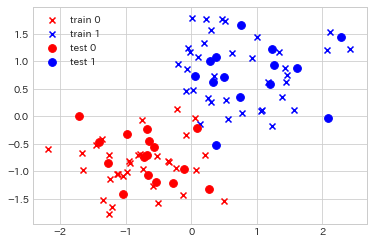

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
 
np.random.seed(seed=0)
X_0 = np.random.multivariate_normal( [2,2],  [[2,0],[0,2]],  50 )
y_0 = np.zeros(len(X_0))
 
X_1 = np.random.multivariate_normal( [6,7],  [[3,0],[0,3]],  50 )
y_1 = np.ones(len(X_1))
 
X = np.vstack((X_0, X_1))
y = np.append(y_0, y_1)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
 
# 特徴データを標準化(平均 0、標準偏差 1)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
 
plt.scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], color='red', marker='x', label='train 0')
plt.scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], color='blue', marker='x', label='train 1')
plt.scatter(X_test_std[y_test==0, 0], X_test_std[y_test==0, 1], color='red', marker='o', s=60, label='test 0')
plt.scatter(X_test_std[y_test==1, 0], X_test_std[y_test==1, 1], color='blue', marker='o', s=60, label='test 1')
 
plt.legend(loc='upper left')


In [12]:
y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [22]:
from sklearn.datasets import make_blobs

In [39]:
X, label = make_blobs(n_samples=1000, centers=[(0,0, 0), (5, 5, 5), (-5, -5, -5)], n_features=3, random_state=0)

In [40]:
learning = pd.concat([pd.DataFrame(X), pd.Series(label)], axis=1)

In [41]:
learning.columns = ['x', 'y', 'z', 'label']
learning.head()

,x,y,z,label
0,-6.012673,-6.027297,-4.676643,2
1,0.771406,1.029439,-0.908763,0
2,-7.263660,-4.624980,-5.082344,2
3,-5.334622,-5.879557,-5.300007,2
4,6.098304,4.862161,5.025386,1


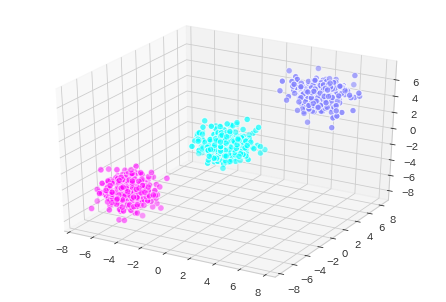

In [60]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(learning.loc[:, 'x'], learning.loc[:, 'y'], learning.loc[:, 'z'], c=learning.loc[:, 'label'], cmap='cool', edgecolor='white', s=40)
#ax.sca(x='x', y='y', data=learning, hue='label', fit_reg=False)